In [1]:
from fastai.imports import *
from fastai.structured import *

In [2]:
!ls

 Data_Train.xlsx	  Sample_submission.xlsx   train.csv
'duration column.ipynb'   sub.csv		   trainRaw
 edit.ipynb		  submission2.xlsx	   tsp.csv
 fastai			  test.csv		   tssp.csv
 featherwali.ipynb	  test-raw		   tst.csv
 final.csv		  testRaw		   Untitled1.ipynb
'lgbm model.ipynb'	  Test_set.xlsx		   Untitled2.ipynb
 sample.csv		  ticket.ipynb		   Untitled.ipynb


In [3]:
df_raw = pd.read_feather('trainRaw')

In [4]:
df_trn, y_trn, nas = proc_df(df_raw, 'Price')

In [5]:
df_trn.head()

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,timeYear,timeMonth,...,timeIs_month_end,timeIs_month_start,timeIs_quarter_end,timeIs_quarter_start,timeIs_year_end,timeIs_year_start,timeHour,timeMinute,timeSecond,timeElapsed
0,2,1,6,4,1343,280,2,9,2019,1,...,False,False,False,False,False,False,8,50,0,1546505400
1,2,1,6,29,614,146,1,1,2019,1,...,False,False,False,False,False,False,11,50,0,1546516200
2,5,1,6,6,531,90,1,1,2019,1,...,False,False,False,False,False,False,14,5,0,1546524300
3,5,1,6,6,464,156,1,9,2019,1,...,False,False,False,False,False,False,7,0,0,1546498800
4,4,1,6,19,1233,242,5,9,2019,1,...,False,False,False,False,False,False,18,25,0,1546539900


In [6]:
y_trn[:10]

array([17135, 14594, 22270, 26890, 12649, 22270, 57209,  9694, 12599, 13439])

In [7]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 2000  # same as Kaggle's test set size
n_trn = len(df_raw)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((8683, 24), (8683,), (2000, 24))

In [8]:
y_valid.shape

(2000,)

In [9]:
X_train.shape

(8683, 24)

In [10]:
y_train.shape

(8683,)

In [11]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [12]:
Classifier = RandomForestRegressor(n_estimators=100, min_samples_leaf=30, max_features=0.3, n_jobs=-1, oob_score=True)
%time Classifier.fit(X_train, y_train)

CPU times: user 1.27 s, sys: 4.41 ms, total: 1.27 s
Wall time: 568 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.3, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=30, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [13]:
y_pred=Classifier.predict(X_valid)

In [14]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [15]:
print_score(Classifier)

[2108.639944631411, 1795.5707402639503, 0.8020635676135096, 0.7961136196786067, 0.7875245748285988]


In [16]:
fi = rf_feat_importance(Classifier, df_trn); fi[:10]

,cols,imp
6,Total_Stops,0.338006
0,Airline,0.141780
11,timeDay,0.105865
3,Route,0.105606
23,timeElapsed,0.073088
13,timeDayofyear,0.048282
2,Destination,0.037320
5,Duration,0.032691
7,Additional_Info,0.031866
9,timeMonth,0.016014


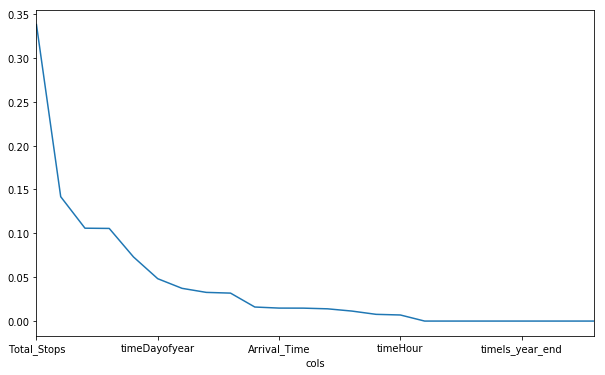

In [17]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [18]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

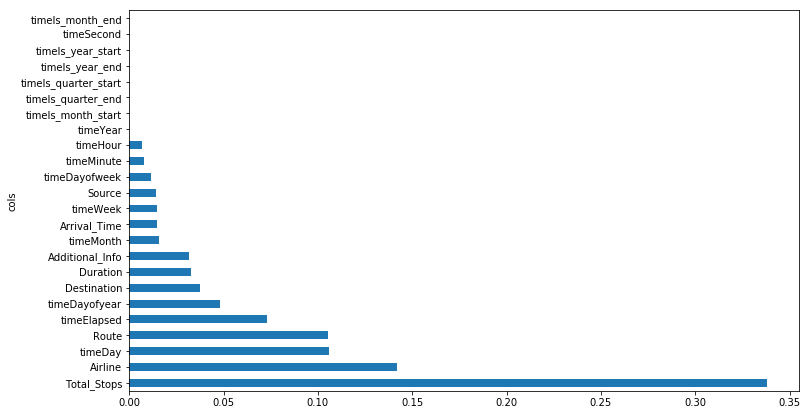

In [19]:
plot_fi(fi[:30]);

In [20]:
to_keep = fi[fi.imp>0.006].cols; len(to_keep)

16

In [21]:
df_keep = df_trn[to_keep].copy()

In [22]:
df_keep.head()

,Total_Stops,Airline,timeDay,Route,timeElapsed,timeDayofyear,Destination,Duration,Additional_Info,timeMonth,Arrival_Time,timeWeek,Source,timeDayofweek,timeMinute,timeHour
0,2,2,3,4,1546505400,3,6,280,9,1,1343,1,1,3,50,8
1,1,2,3,29,1546516200,3,6,146,1,1,614,1,1,3,50,11
2,1,5,3,6,1546524300,3,6,90,1,1,531,1,1,3,5,14
3,1,5,3,6,1546498800,3,6,156,9,1,464,1,1,3,0,7
4,5,4,3,19,1546539900,3,6,242,9,1,1233,1,1,3,25,18


In [23]:
df_keep.columns

Index(['Total_Stops', 'Airline', 'timeDay', 'Route', 'timeElapsed',
       'timeDayofyear', 'Destination', 'Duration', 'Additional_Info',
       'timeMonth', 'Arrival_Time', 'timeWeek', 'Source', 'timeDayofweek',
       'timeMinute', 'timeHour'],
      dtype='object')

In [24]:
df_keep.shape

(10683, 16)

In [25]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 2000 # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

NameError: name 'df' is not defined

In [26]:
X_train, _ = split_vals(df_trn, 2000)
y_train, _ = split_vals(y_trn, 2000)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, y_trn, test_size = 0.2, random_state = 0)

NameError: name 'train_test_split' is not defined

In [27]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [28]:
print_score(m)

[1178.1114924981168, 1715.7320275993243, 0.9347782591760285, 0.8609724727292719, 0.8709787115044267]


In [29]:
??proc_df